---

<h1><center>SDSE Lab 5 <br><br> Scikit-learn, logistic regression, feature selection, and regularization</center></h1>

---

In this lab we will build a model for diagnosing breast cancer from various measurements of the tumor. This lab also introduces [scikit-learn](https://scikit-learn.org/stable/), which is a package for performing a host of machine learning tasks. This model building activity will demonstrate the use of scikit-learn's train-test data splitter, standard scaler, pipelines, cross-validation, and LASSO regularization. 


There are 15 parts split into four sections.

**Prelminaries**

1. Load the data
2. Extract test data
3. Normalize the data

**Simple logistic regression**

4. Most correlated feature
5. Train simple logistic regression
6. Cross-validation
7. Create a scikit-learn pipeline
8. Test simple linear regression

**Set selection**

9. Forward stepwise selection
10. Backward stepwise selection
11. Selected model

**Regularization**

12. LASSO regularized logistic regression
13. Selected model
14. Best features
15. Final model performance




In [86]:
# Initialize Otter
import otter
grader = otter.Notebook("lab5.ipynb")

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
rng_seed = 454


---

<h1><center><font color='purple'> Preliminaries</font><br></center></h1>


# 1. Load the data

This is a [classic dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) that originates at the University of Wisconsin and is included in the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php), as well as in scikit-learn's collection of [toy datasets](https://scikit-learn.org/stable/datasets/toy_dataset.html). It can be loaded with the [load_breast_cancer](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html) method. Passing `as_frame=True` prompts this method to return a pandas DataFrame. 

This dataset encodes a benign tumor as a 1 and a malignant tumor as a 0. We'll flip this so that the encoding aligns with our common notion of "positive" and "negative" diagnoses. 

In [88]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True).frame # as_frame=True means load as a Pandas dataframe
data['target'] = 1-data['target'] # set benign (tumor doesn't exist) = 0 and malignant (tumor exists) = 1

Use `data.info()` to display a summary of the dataset. 

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

# 2. Extract test data

The first step is to set aside a portion of the data for final testing. Use scikit-learn's [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) to create a 20/80 split between testing and training datasets. 

Note: `train_test_split` takes these arguments:
1. The model input samples: Use `data.iloc` to select all rows and all but the last column. 
2. The model output samples: The last column of `data` (named "target")
3. `test_size` is the portion of the data reserved for testing. 
4. Always pass `random_state=rng_seed` to fix the random seed and ensure reproducibility of the results. 

In [90]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(data.iloc[:,:-1],
                                                data['target'], 
                                                test_size=0.20, # 20/80 test data split
                                                random_state=rng_seed ) 

In [91]:
grader.check("q2")

q2 results: All test cases passed!

# 3. Normalize the data

Normalizing the data (i.e. subtracting the mean and dividing by the standard deviation) can be useful for improving the numerical behavior of the training process. From a theoretical standpoint, normalizing the data should have no impact on un-regularized logistic regression; logistic regression is a "scale invariant" model. However it can be helpful for several reasons:
a) It improves numerical stability by equalizing the scales of the features. 
b) It enables comparisons between feature coefficients (a larger coefficient implies greater influence of the feature).
c) We typically want some degree of regularization, and regularized logistic regression is not scale invariant. 

Here we will use a [`StandardScaler`](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) preprocessing object to create normalized versions of the training and test data. The training data is done for you. Repeat the process to obtain a normalized version of the test data. 

In [92]:
from sklearn.preprocessing import StandardScaler

Xtrain_norm = StandardScaler().fit_transform(Xtrain) # this returns nparray, hence why below we use pd.Dataframe to convert back
Xtrain_norm = pd.DataFrame(Xtrain_norm, index=Xtrain.index, columns=Xtrain.columns)

Xtest_norm = StandardScaler().fit_transform(Xtest)
Xtest_norm = pd.DataFrame(Xtest_norm, index=Xtest.index, columns=Xtest.columns)

In [93]:
grader.check("q3")

q3 results: All test cases passed!


---

<h1><center><font color='purple'> Simple logistic regression</font><br></center></h1>


# 4. Most correlated feature

Our first model will be a simple logistic regression model based on the single feature that best correlates with the output. Find this feature and save its name (header value) to `best_single_feature`. 

Note: The tests for this part are hidden.

In [94]:
# Simple logistic regression is one input to one output
data_corr = data.corr()
col_data_corr = data_corr.iloc[:,-1]
col_data_corr_abs = col_data_corr.abs()
col_data_corr_sort = col_data_corr_abs.sort_values(ascending=False)
col_data_corr_sort = col_data_corr_sort.tail(-1)
col_data_corr_best = col_data_corr_sort.head(1)
best_single_feature = col_data_corr_best.index[0]

# 5. Train simple logistic regression

Next we train the simple logistic regression model for the feature that was selected in the previous part. We will use scikit-learn's implementation of [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) for this purpose. 

1. Pass `random_state=rng_seed` into the LogisticRegression constructor to ensure repeatability of the results. 
2. Call the [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.fit) function of the model object, passing in the training data. In this case the model inputs correspond to the single best feature already identified.
3. Extract the trained model coefficients. The intercept term $\theta_0$ is contained in the `intercept_[0]` attribute of the model. The remaining coefficients $\theta_1$ through $\theta_P$ (in this case just $\theta_1$) are in `coef_[0,:]`.

This has been done for you with the original (un-normalized) input data. Repeat the exercise with the normalized data. 

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# Train unnormalized data
model_nonorm = LogisticRegression(random_state=rng_seed)
model_nonorm.fit(Xtrain[[best_single_feature]],ytrain) 
print(model_nonorm.intercept_[0], model_nonorm.coef_[0,:])

# Train normalized data and compare the performance
model_norm = LogisticRegression(random_state=rng_seed)
model_norm.fit(Xtrain_norm[[best_single_feature]],ytrain)
print(model_norm.intercept_[0], model_norm.coef_[0,:])

-1.4650745287470321 [7.80674558]
-1.085050522907755 [3.44438434]


In [96]:
grader.check("q5")

q5 results: All test cases passed!

# 6. Accuracy by cross-validation

Accuracy is an important performance metric for classification models. It is computed as the ratio of correct predictions to total predictions. Hence it approximates the probability that the prediction is correct. 

K-fold cross-validation is an evaluation technique that provides a more robust estimate of model performance (e.g. accuracy) than simple evaluation. It does this by splitting the training set into K equal parts (or "folds"), and then training K separate models, each with one of the K parts as validation data and the others as training data. 

Cross-validation is implemented in scikit-learn's [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) function. We will use 3-fold cross-validation to evaluate the accuracy of both the un-normalized and normalized models.

Note the following:
1. The first three arguments for the `cross_val_score` are the model, the training input data, and the training output data. These last two entries are the same as were passed to the `fit` function in the previous part. 
2. Use `scoring='accuracy'` to set the evaluation metric to accuracy. Use `cv=3` to set the number of folds to 3. 
3. The function should return 3 values of accuracy -- one for each of the folds. Store the *mean* of these as `acc_nonorm` and `acc_norm` for the un-normalized and normalized models respectively. 
4. Note the improvement due to normalization!

In [97]:
from sklearn.model_selection import cross_val_score

acc_nonorm = np.mean(cross_val_score(model_nonorm, Xtrain[[best_single_feature]], ytrain, scoring='accuracy', cv=3))
acc_norm = np.mean(cross_val_score(model_norm, Xtrain_norm[[best_single_feature]], ytrain, scoring='accuracy', cv=3))
print(acc_nonorm)
print(acc_norm)

0.7186882769838503
0.9077785523411176


In [98]:
grader.check("q6")

q6 results: All test cases passed!

# 7. Create a pipeline

Testing the model using `Xtest_norm` presents a problem. This test dataset was created by normalizing `Xtest`, however we will usually apply the model to individual samples (tumor measurements), and hence we will not have a standard deviation to divide by. Instead, we will have to normalize using the mean and standard deviations of the *training* data. Hence, these values become parameters of a larger model that includes the StandardScaler and any other preprocessing steps. 

Scikit-learn provides a *pipeline* class to collects all of the preprocessing, feature transformation, and modeling components into a single object with `fit` and `predict` methods. You can  read the documentation on [pipelines](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html) to learn more. 

Each component in the pipeline is identified with a string name. The following code creates a pipeline with a `StandardScaler` tagged as `scaler`, followed by a logistic regression model tagged as `logreg`.

``` python
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(random_state=rng_seed)) ])
```

Train the pipeline using its `fit` method, and evaluate its accuracy with 3-fold cross-validation. 

In [99]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('scaler', StandardScaler()), 
                 ('logreg', LogisticRegression(random_state=rng_seed)) ])
pipe.fit(Xtrain[[best_single_feature]], ytrain) 

Pipeline(steps=[('scaler', StandardScaler()),
                ('logreg', LogisticRegression(random_state=454))])

In [100]:
grader.check("q7")

q7 results: All test cases passed!

# 8. Test simple linear regression

Here we will do something that is usually not allowed: we will use the test data on three different models. This is ok in this context because we are not making any modeling decisions based on the outcome. We are simply learning about the differences between the three approaches to simple logistic regression that we have seen thus far: no normalization, normalization without a pipeline, and normalization with a pipeline. 

We will use the [`accuracy_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) method to compute the accuracy in each case. We are not using cross-validation in this case because we do not wish to re-train the models, only to evaluate their performance. 

Notice that `accuracy_score` takes in the true output and the predicted output. Use the `predict` function of the model to obtain the predicted output (we call it `yhat`).  Here are the three cases. In each case you should think about which input to provide to the prediction function: `Xtest[...]` or `Xtest_norm[...]`

+ `acc_nonorm_test`: Test accuracy of `model_nonorm`
+ `acc_norm_test`: Test accuracy of `model_norm`
+ `acc_pipe_test`: Test accuracy of `pipe`

How would you expect these three values to be ordered? Does your result agree with that expectation?

In [101]:
from sklearn.metrics import accuracy_score

yhat = model_nonorm.predict(Xtest[[best_single_feature]])
acc_nonorm_test = accuracy_score(ytest, yhat)

yhat = model_norm.predict(Xtest_norm[[best_single_feature]])
acc_norm_test = accuracy_score(ytest, yhat)

yhat = pipe.predict(Xtest_norm[[best_single_feature]])
acc_pipe_test = accuracy_score(ytest, yhat)

In [102]:
grader.check("q8")

q8 results: All test cases passed!


---

<h1><center><font color='purple'>Set selection</font><br></center></h1>



# 9. Forward stepwise selection

Following is code that executes forward stepwise feature selection according to the pseudo-code provided in the lecture. Read and understand this code. 

+ Make sure that you can map every part to the corresponding part of the pseudo-code.
+ Notice the use of sets and set arithmetic. 
+ The outcomes are stored in dictionary named `fwd`.

This part has no deliverables.

In [103]:
features = Xtrain.columns
P = len(features)
curlyP = set(features)

In [104]:
curlyS = [set() for i in range(P+1)]
acc = np.full(P+1,-np.inf)

for p in range(1,P+1):
    print(p)
    
    curlyA = [set() for i in range(P-p+1)]
    acckappa = np.empty(P-p+1)
    
    remain = np.sort(list(curlyP-curlyS[p-1]))
    for kappa, phip in enumerate(remain):
        
        # Akappa
        curlyA[kappa] = curlyS[p-1].union({phip})
        
        # train the logistic regression model
        xtrain = Xtrain[list(curlyA[kappa])]    
        model = Pipeline([('scaler', StandardScaler()), 
                          ('logreg', LogisticRegression(random_state=rng_seed)) ])
        model.fit(xtrain,ytrain) 
        
        # evaluate the model
        acckappa[kappa] = cross_val_score(model, xtrain, ytrain, cv=3, scoring='accuracy').mean()

    kappastar = np.argmax(acckappa)
        
    curlyS[p] = curlyA[kappastar]
    acc[p] = acckappa[kappastar]

# best p
pstar = np.argmax(acc)

# store the result
fwd = {
    'pstar' : pstar,
    'curlyS' : curlyS,
    'acc' : acc    
}

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


# 10. Backward stepwise selection

Complete the code for backward stepwise selection.

In [105]:
curlyS = [set() for i in range(P+1)]
curlyS[P] = set(features)
acc = np.full(P+1,-np.inf)

for p in range(P-1,0,-1):
    print(p)
        
    curlyA = [set() for i in range(P+1)]
    acckappa = np.empty(P+1) 
    
    candidate_features = np.sort(list(curlyS[p+1])) 
    for kappa, phip in enumerate(candidate_features):
        
        # Akappa
        curlyA[kappa] = curlyS[p+1]-{phip}
        
        # train the logistic regression model
        xtrain = Xtrain[list(curlyA[kappa])]    
        model = Pipeline([('scaler', StandardScaler()), 
                          ('logreg', LogisticRegression(random_state=rng_seed)) ])
        model.fit(xtrain,ytrain) 
        
        # evaluate the model
        acckappa[kappa] = cross_val_score(model, xtrain, ytrain, cv=3, scoring='accuracy').mean()

    kappastar = np.argmax(acckappa)
    curlyS[p] = curlyA[kappastar]
    acc[p] = acckappa[kappastar]

# best p
pstar = np.argmax(acc)

# store the result
bwd = {
    'pstar' : pstar,
    'curlyS' : curlyS,
    'acc' : acc    
}

29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


# 11. Selected model

Follow the prompts in the code cell below. Your answers should be coded and not hard-coded (i.e. the answer entered by hand).

Text(0, 0.5, 'validation accuracy')

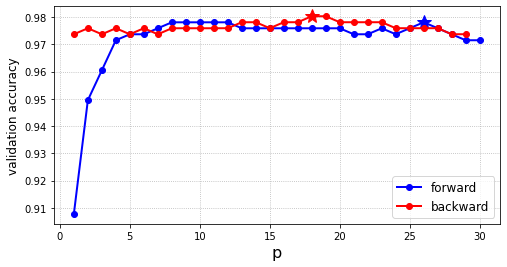

In [106]:
# 1. Set `fwd_pstar` to the optimal number of features chosen by forward selection (from `fwd`).
fwd_pstar = fwd['pstar']

# 2. Set `fwd_features` to the corresponsing optimal set of features 
fwd_features = fwd['curlyS'][fwd_pstar]

# 3. Set `bwd_pstar` to the optimal number of features chosen by backward selection (from `bwd`).
bwd_pstar = bwd['pstar']

# 4. Set `bwd_features` to the corresponsing optimal set of features 
bwd_features = bwd['curlyS'][bwd_pstar]

# 5. Do the two agree on the optimal sets? (boolean answer)
they_agree = fwd_features == bwd_features

# 6. The plot shows the validation accuracy for the forward algorithm as a function of the number of features. 
#    Overlay this plot with the corresponding line for the backward case. 
fig = plt.figure(figsize=(8,4))

plt.plot(range(P+1),fwd['acc'],'o-',color='b',label='forward',linewidth=2)
plt.plot(fwd['pstar'],fwd['acc'][fwd['pstar']],'*',color='b',markersize=14)

plt.plot(range(P+1),bwd['acc'],'o-',color='r',label='backward',linewidth=2)
plt.plot(bwd['pstar'],bwd['acc'][bwd['pstar']],'*',color='r',markersize=14)

plt.legend(fontsize=12)

plt.grid(linestyle=':')
plt.xlabel('p',fontsize=16)
plt.ylabel('validation accuracy',fontsize=12)

In [107]:
grader.check("q11")

q11 results: All test cases passed!


---

<h1><center><font color='purple'>Regularization</font><br></center></h1>


# 12. LASSO regularized logistic regression

General regularization is a method for avoiding overfitting by penalizing the complexity of the model in the training process. LASSO regularization in particular penalizes the sum of the absolute values of the parameters. It has the property that it will tend to "zero out" coefficients as the weight assigned to the penalty ($\lambda$ from the notes) increases. This gives it an additional use as a feature selector. 

In this part we will train a LASSO logistic regression model. Instead of $\lambda$, we will use the `C` parameter of `LogisticRegression`, which is the inverse of $\lambda$. 

The code iterates through a logarithmically spaced array of regularization parameters `C`. For each value it trains and evaluates a logistic regression pipeline with the regularization parameter set to that value. Complete the code. When building the pipeline, you should pass these parameters to the LogisticRegression constructor. 

```python 
C=C[c],
penalty='l1',
solver='liblinear',
```

(in addition to setting the random state). 

In [108]:
C = np.logspace(-2,2,20)
acc = np.empty(20)
models = list()

for c in range(len(C)):   
    
    print(c)
    
    model = Pipeline([('scaler', StandardScaler()), 
                          ('logreg', LogisticRegression(random_state=rng_seed, C=C[c], penalty='l1', solver='liblinear')) ])
    model.fit(Xtrain,ytrain)
    
    models.append(model)

    # Validation accuracy
    acc[c] = cross_val_score(model, Xtrain, ytrain, cv=3, scoring='accuracy').mean()


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [109]:
grader.check("q12")

q12 results: All test cases passed!

# 13. Selected model


The next step is to select the model with the best validation accuracy. Follow the steps in the code. 

Text(0, 0.5, 'Coefficient Value')

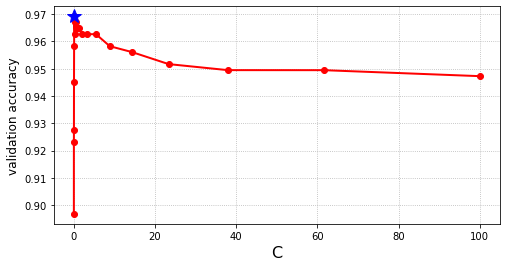

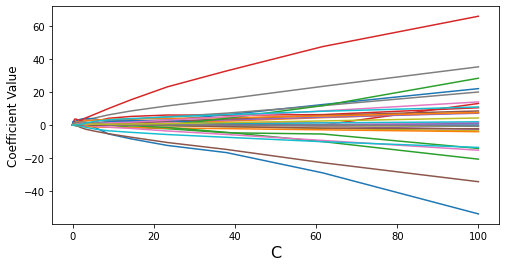

In [110]:
# 1. Set `cstar` to the index of the best performing regularization value
cstar = np.argmax(acc)

# 2. Set `acc_star` to the corresponding accuracy value
acc_star = acc[cstar]

# The next bit of code extracts the coefficients of the logistic regression for each of the 20 values of `C`. 
# This is stored in `theta` , which is a (20,30) array. (30 is the number of features)
theta = np.vstack([model.named_steps['logreg'].coef_[0,:] for model in models])

# 3. Plot the validation accuracy as a function of `C`, just as we plotted it as a function of `p` in part 11.
fig1 = plt.figure(figsize=(8,4))
plt.plot(C,acc,'o-',color='r',label='forward',linewidth=2)
plt.plot(C[cstar],acc_star,'*',color='b',markersize=14)
plt.grid(linestyle=':')
plt.xlabel('C',fontsize=16)
plt.ylabel('validation accuracy',fontsize=12)

# 4. In a single plot, plot the 30 coefficients as a fucntion of `C`.
fig2 = plt.figure(figsize=(8,4))
plt.plot(C, theta)
plt.xlabel('C',fontsize=16)
plt.ylabel('Coefficient Value',fontsize=12)

In [111]:
grader.check("q13")

q13 results: All test cases passed!

# 14. Best features

The plot below shows the coefficients for the best-case regularized logistic regression found in the previous part. Notice that many of these coefficients have been set to zero. 

<StemContainer object of 3 artists>

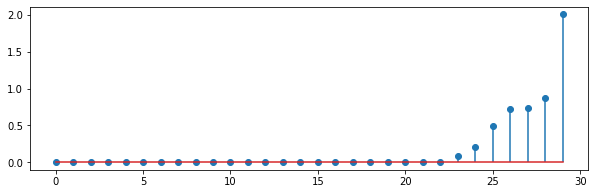

In [112]:
thetastar = theta[cstar,:]
absts = np.abs(thetastar)
sabsts = np.argsort(absts)


plt.figure(figsize=(10,3))
plt.stem(absts[sabsts])

In [113]:
feature_names = np.array(data.columns[:-1])
# 1. Set `best_features` to the set of feature names corresponding to non-zero coefficients in the plot above. 
best_features = set(feature_names[np.where(np.abs(theta_star) > 0)[0]])

# 2. Set `max_theta_feature` to the feature name corresponding to the coefficient with maximum absolute value. 
max_theta_feature = feature_names[np.argmax(np.abs(theta_star))]

# 3. Save the selected lasso model to the variable `lasso`.
lasso = models[cstar]

In [114]:
grader.check("q14")

q14 results: All test cases passed!

# 15. Testing

Use the test dataset to evaluate the accuracy of the selected LASSO model. 

In [115]:
# Make predictions on the test dataset using the trained LASSO model
yhat = lasso.predict(Xtest)

# Evaluating the accuracy of the LASSO model using appropriate performance metrics
from sklearn.metrics import accuracy_score

# Computing the accuracy score
lasso_test = accuracy_score(ytest, yhat)

# Print the accuracy score
print("Accuracy score of the selected LASSO model:", lasso_test)


Accuracy score of the selected LASSO model: 0.9912280701754386


## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [116]:
# Save your notebook first, then run this cell to export your submission.
grader.export(pdf=False)